In [1]:
import os
import sys
import os.path as pth
from time import time
from textwrap import dedent
import json
from zipfile import ZipFile

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from osgeo import gdal, ogr, osr
import shapely
import geopandas as gpd

In [3]:
from geostack.raster import Raster, GeometryType, RasterCombinationType
from geostack.runner import runScript, getSolver
from geostack.io import geoJsonToVector, vectorToGeoJson
from geostack.solvers import NetworkFlowSolver
from geostack.core import ProjectionParameters

In [4]:
def build_grid(nx, ny, ox, oy, hx, hy):
    xx = np.arange(ox, ox+hx*nx, hx)
    yy = np.arange(oy, oy+hy*ny, hy)
    return np.meshgrid(xx, yy)

In [5]:
inp_dir = pth.join(os.getcwd(), "data", "staticEvacuation")
out_dir = os.getcwd()

In [6]:
# Read Input layers for fire and population
fire = Raster(name="fire")
fire.read("%s/test.tif" % inp_dir)

In [7]:
proj_string = "+proj=lcc +lat_1=-36 +lat_2=-38 +lat_0=-37 +lon_0=145 +x_0=2500000 +y_0=2500000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

In [8]:
fire_dimensions = fire.getDimensions()
fire_x, fire_y = build_grid(fire_dimensions.nx ,fire_dimensions.ny,
                            fire_dimensions.ox ,fire_dimensions.oy,
                            fire_dimensions.hx ,fire_dimensions.hy)
evacuationLayerProjection = ProjectionParameters.from_proj4(proj_string)
fire.setProjectionParameters(evacuationLayerProjection)
fire_data = fire.get_full_data()

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                      subplot_kw={'projection':ccrs.epsg('3111')})
cs = ax.pcolormesh(fire_x, fire_y, fire_data, cmap=plt.cm.viridis)
cb = fig.colorbar(cs, ax=ax, shrink=0.7, fraction=0.1)
cb.ax.set_ylabel("seconds", fontsize=14)
ax.set_title("Fire arrival time", fontsize=14);

In [10]:
population = Raster(name="population")
population.read("%s/test_pop_tiled.tif" % inp_dir)

In [11]:
population_dims = population.getDimensions()
population_x, population_y = build_grid(population_dims.nx, population_dims.ny,
                            population_dims.ox, population_dims.oy,
                            population_dims.hx, population_dims.hy)
populationLayerProjection = ProjectionParameters.from_proj4(proj_string)

In [12]:
population.setProjectionParameters(populationLayerProjection)

In [13]:
fire_bounds = fire.getBounds()
fire_bounds.extend(10000.0)

In [14]:
flow = Raster(name="flow")
flow.init_with_bbox(fire_bounds, 180.0)
flow.setProjectionParameters(evacuationLayerProjection)
flow = runScript("output = fire > 0.0 ? 0.0 : 1.0;", [flow, fire],
   parameter=RasterCombinationType.Intersection, output_type=np.float32)
flow.setProperty("name", "flow")

In [15]:
flow_dimensions = flow.getDimensions()
flow_x, flow_y = build_grid(flow_dimensions.nx, flow_dimensions.ny,
                            flow_dimensions.ox, flow_dimensions.oy,
                            flow_dimensions.hx, flow_dimensions.hy)
flow_data = flow.get_full_data()

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                      subplot_kw={'projection':ccrs.epsg('3111')})
cs = ax.pcolormesh(flow_x, flow_y, flow_data, cmap=plt.cm.RdBu)
cb = fig.colorbar(cs, ax=ax, shrink=0.7, fraction=0.1)
cb.set_ticks(mticker.MultipleLocator(1))
ax.set_title("Burnt area mask", fontsize=14);

In [17]:
contourVector = flow.vectorise(0.5, noDataValue=1.0)
with open("%s/vector_contour.geojson" % out_dir, "w") as outfile:
    outfile.write(vectorToGeoJson(contourVector))

In [18]:
contour_json = json.loads(vectorToGeoJson(contourVector))
for i in range(len(contour_json['features'])):
    if 'properties' not in contour_json['features'][i]:
        contour_json['features'][i]['properties'] = {}

In [19]:
bounds = contourVector.getBounds().to_list()

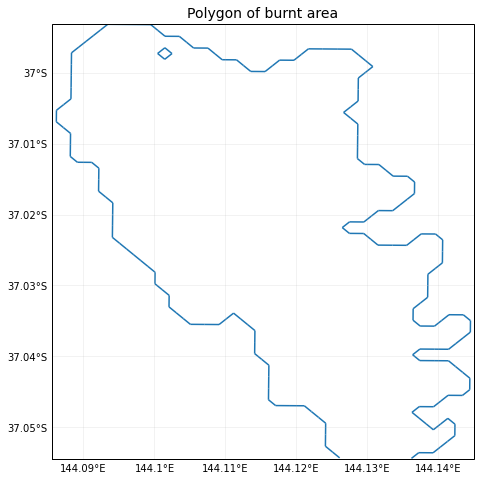

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                        subplot_kw={'projection':ccrs.PlateCarree()})
ax.set_extent([bounds[0][0], bounds[1][0], 
               bounds[0][1], bounds[1][1]], 
              crs=ccrs.epsg('3111'))

subset_df = gpd.GeoDataFrame.from_features(contour_json['features'])
subset_df.plot(ax=ax, transform=ccrs.epsg('3111'))
gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_title("Polygon of burnt area", fontsize=14);

In [21]:
dist = contourVector.mapDistance(180.0, GeometryType.LineString,
                                 fire_bounds)
dist.setProperty("name", "dist")
dist.setProjectionParameters(evacuationLayerProjection)

In [22]:
fire_dist_dimensions = dist.getDimensions()
fire_dist_x, fire_dist_y = build_grid(fire_dist_dimensions.nx, fire_dist_dimensions.ny,
                            fire_dist_dimensions.ox, fire_dist_dimensions.oy,
                            fire_dist_dimensions.hx, fire_dist_dimensions.hy)
fire_dist = dist.get_full_data()

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                      subplot_kw={'projection':ccrs.epsg('3111')})
cs = ax.pcolormesh(fire_dist_x, fire_dist_y, fire_dist)
cb = fig.colorbar(cs, ax=ax, shrink=0.8, fraction=0.1)

subset_df = gpd.GeoDataFrame.from_features(contour_json['features'])
subset_df.plot(ax=ax, transform=ccrs.epsg('3111'), color='r')

cb.ax.set_ylabel("meters", fontsize=12)
ax.set_title("Distance from centroid of burnt area", fontsize=14);

In [24]:
flow = runScript("output = dist < 10000.0 ? population : nodata;", 
                 [dist, population],
                 parameter=RasterCombinationType.Intersection,
                 output_type=np.float32)
flow.setProperty("name", "flow")

In [25]:
flow_dimensions = flow.getDimensions()
flow_x, flow_y = build_grid(flow_dimensions.nx ,flow_dimensions.ny,
                            flow_dimensions.ox ,flow_dimensions.oy,
                            flow_dimensions.hx ,flow_dimensions.hy)
flow.setProjectionParameters(evacuationLayerProjection)
flow_data = flow.get_full_data()

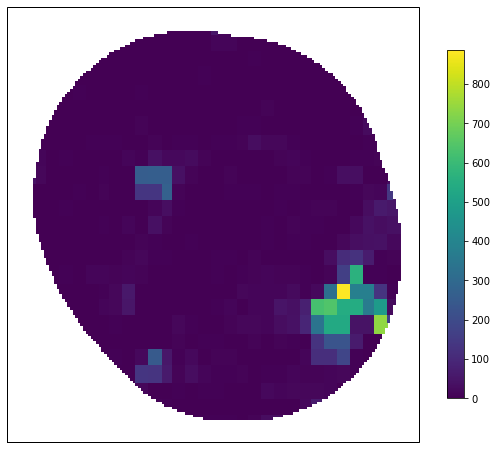

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                      subplot_kw={'projection':ccrs.epsg('3111')})
cs = ax.pcolormesh(flow_x, flow_y, flow_data)
cb = fig.colorbar(cs, ax=ax, shrink=0.8, fraction=0.1)

In [27]:
with ZipFile("%s/test_data_1.zip" % inp_dir) as inp:
    network = geoJsonToVector(inp.read(inp.filelist[0].filename).decode())

In [28]:
EPSG4326 = "(+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs)"
network_projection = ProjectionParameters.from_proj4(EPSG4326)
network.setProjectionParameters(network_projection)

In [29]:
fire_bounds.extend(30000.0)
fire_bounds_proj = fire_bounds.convert(network_projection,
                                       evacuationLayerProjection)
network = network.region(fire_bounds_proj)

In [30]:
network = network.convert(evacuationLayerProjection)
if not network.pointSample(flow):
    raise RuntimeError()

In [31]:
network_json = json.loads(vectorToGeoJson(network))
for i in range(len(network_json['features'])):
    if 'properties' not in network_json['features'][i]:
        network_json['features'][i]['properties'] = {}
network_bounds = network.getBounds().to_list()

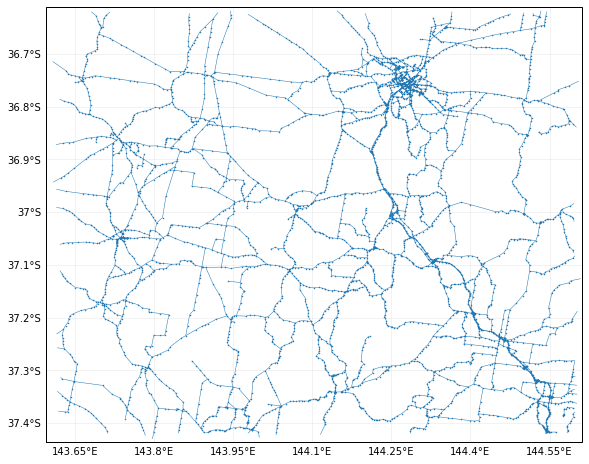

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                        subplot_kw={'projection':ccrs.PlateCarree()})
ax.set_extent([network_bounds[0][0], network_bounds[1][0], 
               network_bounds[0][1], network_bounds[1][1]], 
              crs=ccrs.epsg('3111'))

subset_df = gpd.GeoDataFrame.from_features(network_json['features'])
subset_df.plot(ax=ax, transform=ccrs.epsg('3111'),
               linewidths=0.5, markersize=1)
gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [33]:
networkFlowSolver = NetworkFlowSolver()
jsonConfig = """{"constant": 100.0, "defaultLinkType": 3}"""

In [34]:
networkFlowSolver.init(network, jsonConfig)

In [35]:
networkFlowSolver.run()

True

In [36]:
flow_dimensions = flow.getDimensions()
flow_data = np.zeros(shape=(flow_dimensions.ny ,flow_dimensions.nx))
flow_x, flow_y = build_grid(flow_dimensions.nx ,flow_dimensions.ny,
                            flow_dimensions.ox ,flow_dimensions.oy,
                            flow_dimensions.hx ,flow_dimensions.hy)
flow_data = flow.get_full_data()

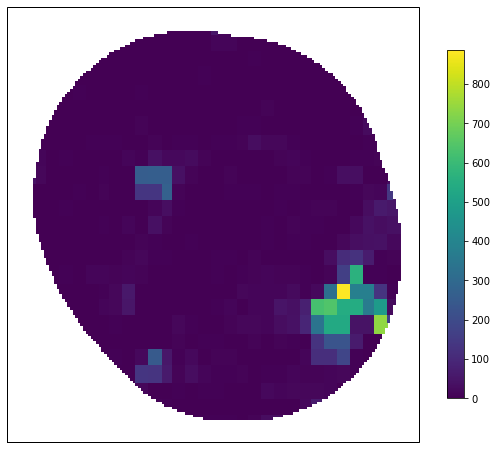

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                      subplot_kw={'projection':ccrs.epsg('3111')})
cs = ax.pcolormesh(flow_x, flow_y, flow_data)
cb = fig.colorbar(cs, ax=ax, shrink=0.8, fraction=0.1)

In [38]:
result_network = networkFlowSolver.getNetwork()
result_network = result_network.convert(network_projection)
network_json = json.loads(vectorToGeoJson(result_network))
network_bounds = result_network.getBounds().to_list()

In [39]:
for i in range(len(network_json['features'])):
    if 'properties' not in network_json['features'][i]:
        network_json['features'][i]['properties'] = {}

In [40]:
with open("out_flow_network.geojson", "w") as out:
    json.dump(network_json, out)

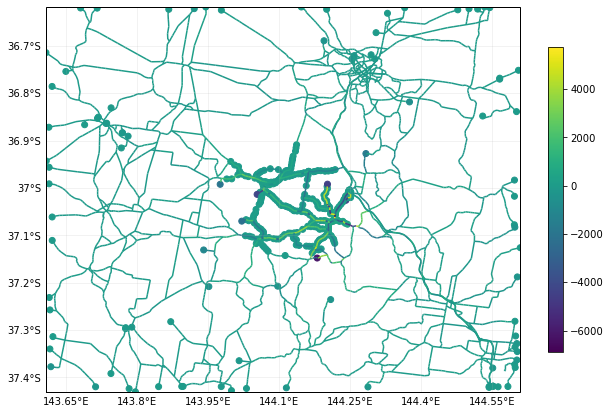

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                        subplot_kw={'projection':ccrs.PlateCarree()})
ax.set_extent([network_bounds[0][0], network_bounds[1][0], 
               network_bounds[0][1], network_bounds[1][1]], 
              crs=ccrs.PlateCarree())

subset_df = gpd.GeoDataFrame.from_features(network_json['features'])
subset_df.plot(ax=ax, transform=ccrs.PlateCarree(),
               column='flow', cmap='viridis', legend=True,
              legend_kwds={'shrink':0.7, 'fraction':0.1})

gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER